In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.model_selection import KFold

In [2]:
df=pd.read_csv('DEMs_exp_log2.csv')

df['SD'][df['SD'] == 3] = 0

df.index = df['Unnamed: 0']
df.drop('Unnamed: 0', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
df.head()

,hsa-miR-375,hsa-miR-29c*,hsa-miR-1258,hsa-miR-132*,hsa-miR-142-3p,hsa-miR-520c-3p,hsa-miR-302b,hsa-miR-204,hsa-miR-1468,hsa-miR-576-5p,hsa-miR-601,hsa-miR-609,hsa-miR-154,hsa-miR-508-3p,hsa-miR-942,hsa-miR-302d,hsa-miR-135b,hsa-miR-522,hsa-miR-488,hsa-miR-1262,hsa-miR-126*,hsa-miR-373,hsa-miR-483-3p,hsa-miR-133a,hsa-miR-190b,hsa-miR-598,hsa-miR-199b-5p,hsa-miR-1282,hsa-miR-1825,hsa-miR-130b*,hsa-miR-578,hsa-miR-520f,hsa-miR-26a-2*,hsa-miR-450a,hsa-miR-29b-1*,hsa-miR-615-3p,hsa-miR-892b,hsa-miR-1290,hsa-miR-556-3p,hsa-miR-98,...,hsa-miR-454*,hsa-miR-613,hsa-miR-302a,hsa-miR-376a*,hsa-miR-9,hsa-miR-520d-3p,hsa-miR-455-5p,hsa-miR-515-5p,hsa-miR-31*,hsa-miR-488*,hsa-miR-200a,hsa-miR-489,hsa-miR-1283,hsa-miR-566,hsa-miR-455-3p,hsa-miR-646,hsa-miR-519b-5p,hsa-miR-1245,hsa-miR-1291,hsa-miR-155*,hsa-miR-31,hsa-miR-518a-5p,hsa-miR-21*,hsa-miR-564,hsa-miR-933,hsa-miR-589,hsa-miR-545*,hsa-miR-520d-5p,hsa-miR-518d-5p,hsa-miR-96*,hsa-miR-136*,hsa-miR-491-3p,hsa-miR-568,hsa-miR-450b-5p,hsa-miR-556-5p,hsa-miR-10b*,hsa-miR-298,hsa-miR-889,hsa-miR-518d-3p,SD
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GSM1512142,1.000000,4.262995,4.262995,1.0,6.420548,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,4.262995,1.0,1.000000,2.336774,1.0,2.336774,1.000000,1.0,1.000000,1.000000,6.728644,5.450346,1.0,1.000000,1.000000,2.336774,6.248638,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.450346,4.262995,5.014422,1.0,4.262995,...,1.000000,1.0,1.0,1.0,4.262995,1.0,1.000000,7.828533,7.828533,7.059014,6.728644,8.273836,6.728644,7.319222,7.319222,9.504007,8.052603,6.248638,6.420548,4.262995,7.059014,8.455011,7.059014,7.828533,8.373233,6.248638,4.262995,6.420548,7.222831,6.728644,5.450346,6.420548,6.248638,5.781078,7.059014,6.038019,8.455011,1.000000,5.450346,0.0
GSM1512143,1.000000,1.000000,1.000000,1.0,4.370692,1.000000,1.0,1.0,1.0,1.0,1.391073,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.391073,1.0,1.000000,3.136886,6.436324,5.240589,1.0,3.136886,3.136886,1.000000,6.284242,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.240589,4.370692,1.391073,1.0,3.846243,...,1.000000,1.0,1.0,1.0,3.846243,1.0,1.391073,8.349497,8.656972,6.356608,6.436324,8.090505,6.170350,6.529228,7.960402,8.606451,7.835585,4.370692,7.004594,4.370692,7.336514,7.687020,4.370692,7.275976,8.201368,6.067018,5.062997,5.628266,8.431464,8.285002,6.170350,6.684122,6.836845,5.949447,7.336514,6.284242,7.150665,5.062997,5.062997,0.0
GSM1512144,1.000000,4.888494,1.000000,1.0,7.254011,1.654871,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,5.710041,1.000000,1.0,1.000000,1.000000,1.0,5.406824,1.000000,5.710041,6.701950,1.0,6.167703,1.654871,1.000000,5.824839,1.000000,4.888494,1.000000,4.050694,1.654871,1.654871,1.000000,5.580730,1.000000,1.0,7.643808,...,1.000000,1.0,1.0,1.0,1.000000,1.0,1.654871,6.768200,7.093676,5.935992,6.423491,7.036954,6.423491,5.935992,7.093676,7.575507,6.932835,5.710041,6.932835,4.470609,6.895560,7.093676,6.964425,7.332490,7.383830,6.574513,4.050694,5.935992,7.212345,7.212345,5.406824,6.340894,6.064883,5.935992,7.136268,5.853284,6.340894,4.470609,6.064883,0.0
GSM1512145,3.992913,1.000000,1.000000,1.0,6.236254,3.992913,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,2.484653,5.198381,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,6.071196,1.0,6.236254,1.000000,1.000000,1.000000,2.484653,1.000000,2.484653,1.000000,1.000000,3.992913,2.484653,1.000000,3.992913,1.0,7.413773,...,3.992913,1.0,1.0,1.0,2.484653,1.0,3.992913,7.215294,7.687020,6.071196,6.990446,7.083919,6.720574,6.071196,7.083919,7.592523,7.215294,5.576247,6.806830,5.847563,6.720574,7.215294,6.621930,6.720574,7.158045,5.847563,5.198381,6.236254,7.336514,7.476855,5.576247,6.523319,6.236254,5.847563,7.687020,6.236254,5.847563,5.198381,5.198381,0.0
GSM1512146,1.000000,3.155257,1.000000,1.0,4.745715,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,3.155257,5.822897,1.0,4.745715,1.000000,1.000000,4.745715,1.00000

In [ ]:
df['SD'].value_counts()

0.0    94
1.0    62
Name: SD, dtype: int64

**NOTE:** '0' classs represents 'Healthy' and '1' class represents 'MI'.

**Question:** Should I try to make number of each class samples equal by upsampling, downsampling or any other algorithm or not?

In [ ]:
corr = df.corr()
corr = corr[corr < 1]
corr[corr >= 0.8].sum().sum()

0.0

In [ ]:
corr[corr <= -0.8].sum().sum()

0.0

**NOTE:** There is no couple of strongly correlated mirs.

In [ ]:
df_melt=pd.melt(df, id_vars='SD')

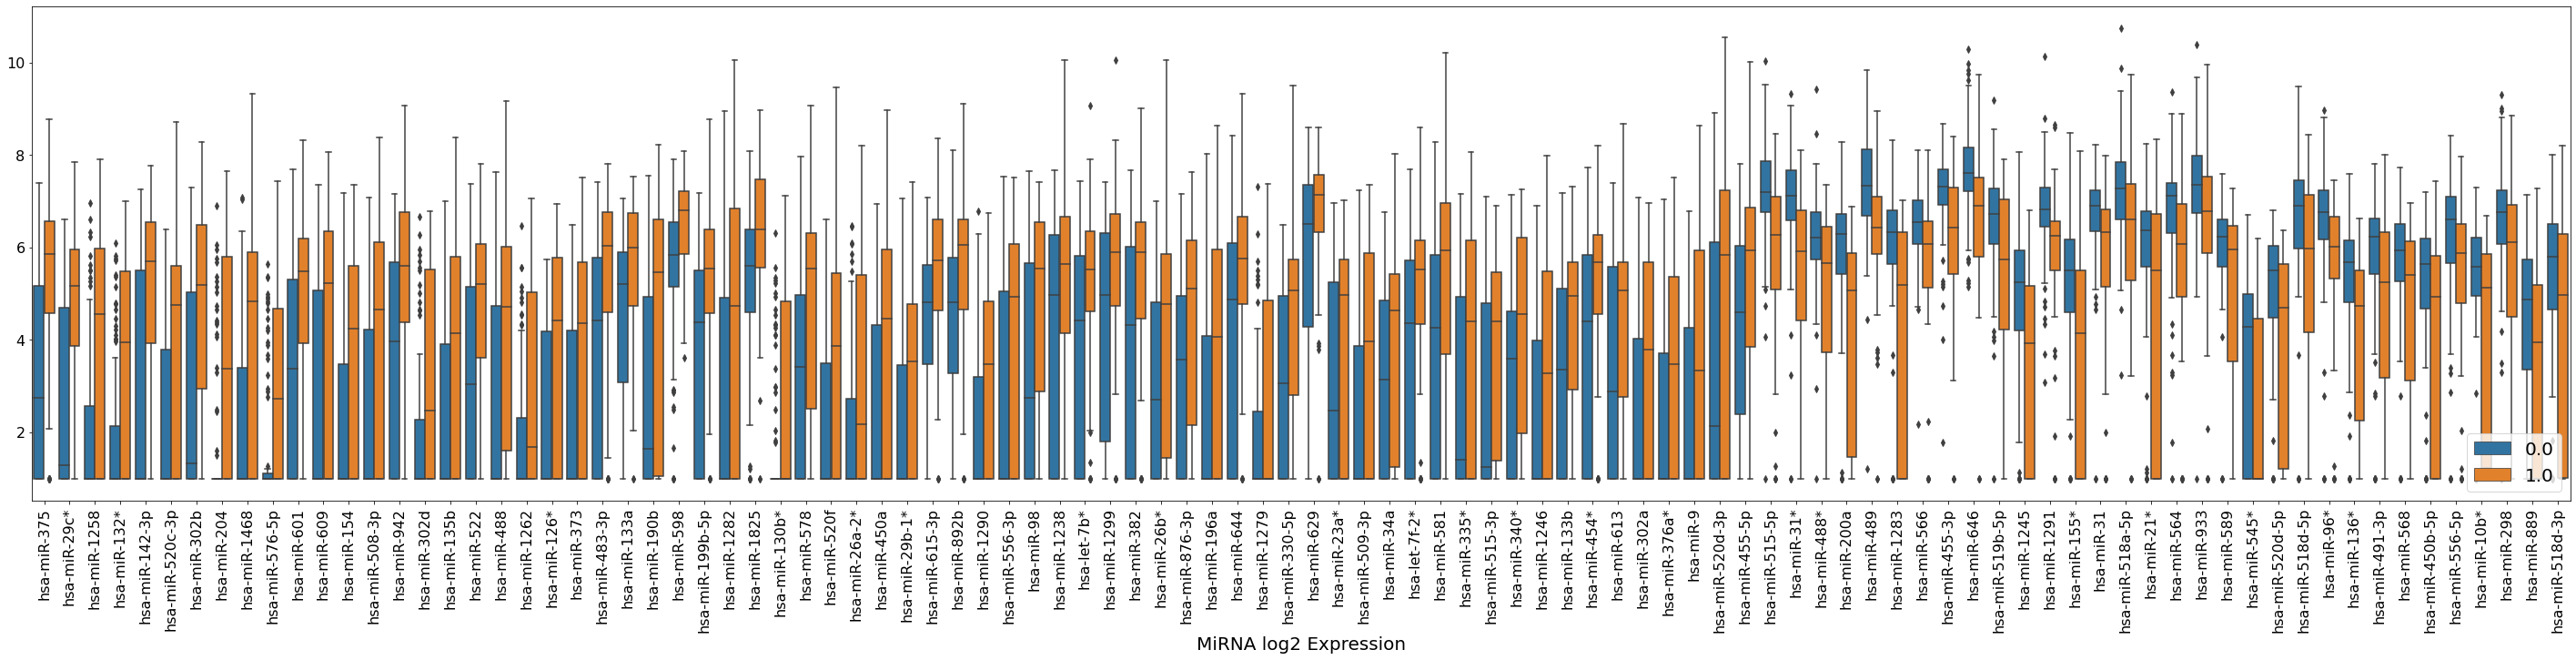

In [ ]:
plt.figure(figsize=(50,10))
sns.boxplot(x="variable", y="value", hue='SD', data=df_melt);
plt.ylabel('', fontsize = 20)
plt.xlabel('MiRNA log2 Expression', fontsize = 20)
plt.legend(loc='lower right', prop={'size':20})
plt.tick_params(axis='x', which='major', labelsize=15, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('Expression.pdf', bbox_inches='tight')

**Question:** Should I normalize the data that are all from one type of data? What about outlier detection and deletion?

In [4]:
#defining scoring for all furthur uses in cross validation
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']

# Random Forest

## Basic Random Forest

In [5]:
# Seperating informative and target data, and splitting it into train and test
X=df.drop('SD', axis=1)
y=df['SD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [6]:
Basic_RF=RandomForestClassifier(random_state=1)
scores = cross_validate(Basic_RF, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True, return_estimator =True)
scores1=pd.DataFrame(scores).drop(['estimator'], axis=1)
scores1

,fit_time,score_time,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,0.277954,0.036770,0.770833,1.0,0.770833,1.0,0.770833,1.0,0.818182,1.0
1,0.283880,0.038667,0.900000,1.0,0.666667,1.0,0.694444,1.0,0.818182,1.0
2,0.302519,0.036006,0.300000,1.0,0.428571,1.0,0.352941,1.0,0.545455,1.0
3,0.284396,0.037224,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,0.298687,0.037786,0.318182,1.0,0.500000,1.0,0.388889,1.0,0.636364,1.0
5,0.289889,0.037712,0.607143,1.0,0.607143,1.0,0.607143,1.0,0.636364,1.0
6,0.292892,0.036343,0.803571,1.0,0.803571,1.0,0.803571,1.0,0.818182,1.0
7,0.305756,0.037785,0.888889,1.0,0.750000,1.0,0.770833,1.0,0.818182,1.0
8,0.306378,0.036769,0.318182,1.0,0.500000,1.0,0.388889,1.0,0.636364,1.0
9,0.295448,0.041735,0.937500,1.0,0.833333,1.0,0.866667,1.0,0.900000,1.0


In [7]:
cols=list(scores1.columns)
cols[0]='Model'
cols[1]='No. of miRs' 

In [8]:
result1=list(scores1.mean(axis=0))
result1[0]='Basic Random Forest'
result1[1]='100'
results = pd.DataFrame([result1], columns=cols)
results

,Model,No. of miRs,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,Basic Random Forest,100,0.68443,1.0,0.686012,1.0,0.664421,1.0,0.762727,1.0


### Training the model with the best 6 from the basic random forest


In [9]:
# Selecting the most important miRNAs by finding the most repeated ones in all 10 cross validation
imp_mirs=[]
for idx,estimator in enumerate(scores['estimator']):
    imp=estimator.feature_importances_
    mirs= list(estimator.feature_names_in_[imp.argsort()[-10:][::-1]])
    imp_mirs+=mirs

imp_mirs=pd.DataFrame({'miRs': imp_mirs})
count=pd.DataFrame({'count':imp_mirs['miRs'].value_counts()})
imp_mirs=list(count.index[0:6])
imp_mirs

['hsa-miR-488*',
 'hsa-miR-133a',
 'hsa-miR-132*',
 'hsa-miR-483-3p',
 'hsa-miR-126*',
 'hsa-miR-892b']

In [10]:
X_temp=df[imp_mirs]
y_temp=df['SD']
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=1)

In [11]:
Basic_RF_6mirs=RandomForestClassifier(random_state=1)
scores = cross_validate(Basic_RF_6mirs, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True, return_estimator =True)
scores2=pd.DataFrame(scores).drop(['estimator'], axis=1)
scores2

,fit_time,score_time,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,0.258602,0.035751,0.770833,1.0,0.770833,1.0,0.770833,1.0,0.818182,1.0
1,0.268350,0.037582,0.363636,1.0,0.500000,1.0,0.421053,1.0,0.727273,1.0
2,0.308233,0.038850,0.708333,1.0,0.678571,1.0,0.685714,1.0,0.727273,1.0
3,0.317792,0.037066,0.900000,1.0,0.928571,1.0,0.905983,1.0,0.909091,1.0
4,0.286441,0.036081,0.850000,1.0,0.625000,1.0,0.611765,1.0,0.727273,1.0
5,0.268128,0.036865,0.607143,1.0,0.607143,1.0,0.607143,1.0,0.636364,1.0
6,0.307395,0.036306,0.716667,1.0,0.732143,1.0,0.717949,1.0,0.727273,1.0
7,0.290733,0.036728,0.607143,1.0,0.607143,1.0,0.607143,1.0,0.636364,1.0
8,0.274348,0.035628,0.708333,1.0,0.678571,1.0,0.685714,1.0,0.727273,1.0
9,0.255752,0.035530,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


In [12]:
result2=list(scores2.mean(axis=0))
result2[0]='Basic Random Forest'
result2[1]='6'
result2 = pd.DataFrame([result2], columns=cols)
results = pd.concat([results, result2], axis=0)
results

,Model,No. of miRs,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,Basic Random Forest,100,0.684430,1.0,0.686012,1.0,0.664421,1.0,0.762727,1.0
0,Basic Random Forest,6,0.723209,1.0,0.712798,1.0,0.701330,1.0,0.763636,1.0


## Grid Search

### All together

In [13]:
# Seperating informative and target data, and splitting it into train and test
X=df.drop('SD', axis=1)
y=df['SD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
param_grid = {
    'n_estimators' : [50, 100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 6, 9, 15],
    'max_features' : [2, 3, 4, 5, 6]
}
base_estimator = RandomForestClassifier(random_state=1, n_jobs=-1)
grid_search=GridSearchCV(base_estimator, scoring='accuracy', param_grid=param_grid, cv=10, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9, 15],
                         'max_features': [2, 3, 4, 5, 6],
                         'n_estimators': [50, 100, 200, 300]},
             refit=False, scoring='accuracy')

In [ ]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 3,
 'n_estimators': 100}

In [14]:
GS_best_RF=RandomForestClassifier(criterion='entropy', max_depth=15, max_features=3,n_estimators=100)
scores = cross_validate(GS_best_RF, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True, return_estimator =True)
scores3=pd.DataFrame(scores).drop(['estimator'], axis=1)
scores3

,fit_time,score_time,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,0.285707,0.037112,0.770833,1.0,0.770833,1.0,0.770833,1.0,0.818182,1.0
1,0.291546,0.037663,0.900000,1.0,0.666667,1.0,0.694444,1.0,0.818182,1.0
2,0.274321,0.037656,0.277778,1.0,0.357143,1.0,0.312500,1.0,0.454545,1.0
3,0.284118,0.038239,0.803571,1.0,0.803571,1.0,0.803571,1.0,0.818182,1.0
4,0.288957,0.036044,0.318182,1.0,0.500000,1.0,0.388889,1.0,0.636364,1.0
5,0.301702,0.038711,0.583333,1.0,0.553571,1.0,0.541667,1.0,0.636364,1.0
6,0.297183,0.037739,0.803571,1.0,0.803571,1.0,0.803571,1.0,0.818182,1.0
7,0.279661,0.038498,0.888889,1.0,0.750000,1.0,0.770833,1.0,0.818182,1.0
8,0.289136,0.037589,0.300000,1.0,0.428571,1.0,0.352941,1.0,0.545455,1.0
9,0.271721,0.037241,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


In [15]:
result3=list(scores3.mean(axis=0))
result3[0]='Random Forest Best parameters by Grid Search'
result3[1]='100'
result3 = pd.DataFrame([result3], columns=cols)
results = pd.concat([results, result3], axis=0)
results

,Model,No. of miRs,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,Basic Random Forest,100,0.684430,1.0,0.686012,1.0,0.664421,1.0,0.762727,1.0
0,Basic Random Forest,6,0.723209,1.0,0.712798,1.0,0.701330,1.0,0.763636,1.0
0,Random Forest Best parameters by Grid Search,100,0.664616,1.0,0.663393,1.0,0.643925,1.0,0.736364,1.0


#### Training the GS best model with the best 6 from the GS best random forest




In [16]:
# Selecting the most important miRNAs by finding the most repeated ones in all 10 cross validation
imp_mirs=[]
for idx,estimator in enumerate(scores['estimator']):
    imp=estimator.feature_importances_
    mirs= list(estimator.feature_names_in_[imp.argsort()[-10:][::-1]])
    imp_mirs+=mirs

imp_mirs=pd.DataFrame({'miRs': imp_mirs})
count=pd.DataFrame({'count':imp_mirs['miRs'].value_counts()})
imp_mirs=list(count.index[0:6])
imp_mirs

['hsa-miR-1291',
 'hsa-miR-126*',
 'hsa-miR-646',
 'hsa-miR-155*',
 'hsa-miR-133a',
 'hsa-miR-483-3p']

In [17]:
X_temp=df[imp_mirs]
y_temp=df['SD']
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=1)

In [18]:
GS_best_RF_6mirs=RandomForestClassifier(criterion='entropy', max_depth=15, max_features=3,n_estimators=100)
scores = cross_validate(GS_best_RF_6mirs, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True, return_estimator =True)
scores4=pd.DataFrame(scores).drop(['estimator'], axis=1)
scores4

,fit_time,score_time,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,0.285433,0.044483,0.770833,1.0,0.770833,1.0,0.770833,1.0,0.818182,1.0
1,0.313285,0.038584,0.678571,1.0,0.708333,1.0,0.685714,1.0,0.727273,1.0
2,0.296867,0.037216,0.607143,1.0,0.607143,1.0,0.607143,1.0,0.636364,1.0
3,0.299983,0.041923,0.900000,1.0,0.928571,1.0,0.905983,1.0,0.909091,1.0
4,0.307784,0.035457,0.583333,1.0,0.553571,1.0,0.541667,1.0,0.636364,1.0
5,0.295418,0.037080,0.708333,1.0,0.678571,1.0,0.685714,1.0,0.727273,1.0
6,0.297373,0.035544,0.833333,1.0,0.857143,1.0,0.816667,1.0,0.818182,1.0
7,0.287722,0.036233,0.888889,1.0,0.750000,1.0,0.770833,1.0,0.818182,1.0
8,0.290217,0.036785,0.850000,1.0,0.625000,1.0,0.611765,1.0,0.727273,1.0
9,0.276489,0.037008,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


In [19]:
result4=list(scores4.mean(axis=0))
result4[0]='Random Forest Best parameters by Grid Search'
result4[1]='6'
result4 = pd.DataFrame([result4], columns=cols)
results = pd.concat([results, result4], axis=0)
results

,Model,No. of miRs,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,Basic Random Forest,100,0.684430,1.0,0.686012,1.0,0.664421,1.0,0.762727,1.0
0,Basic Random Forest,6,0.723209,1.0,0.712798,1.0,0.701330,1.0,0.763636,1.0
0,Random Forest Best parameters by Grid Search,100,0.664616,1.0,0.663393,1.0,0.643925,1.0,0.736364,1.0
0,Random Forest Best parameters by Grid Search,6,0.782044,1.0,0.747917,1.0,0.739632,1.0,0.781818,1.0


### Every time, I have ran the search for one parameter and add the best value for that parameter to the model




In [20]:
# Seperating informative and target data, and splitting it into train and test
X=df.drop('SD', axis=1)
y=df['SD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
param_grid = {
    #'n_estimators' : [50, 100, 200, 300]
    #'criterion' : ['gini', 'entropy']
    #'max_depth' : [3, 6, 9, 15]
    'max_features' : [2, 3, 4, 5, 6]
}
base_estimator = RandomForestClassifier(random_state=1, n_jobs=-1)

grid_search=GridSearchCV(base_estimator, param_grid=param_grid,
                         cv=10, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1, param_grid={'max_features': [2, 3, 4, 5, 6]})

In [21]:
GS_best_RF_1by1=RandomForestClassifier(n_estimators=100, max_depth=9, max_features=6, criterion='entropy', random_state=1, n_jobs=-1)
scores = cross_validate(GS_best_RF_1by1, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True, return_estimator =True)
scores5=pd.DataFrame(scores).drop(['estimator'], axis=1)
scores5

,fit_time,score_time,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,0.386558,0.108099,0.678571,1.0,0.708333,1.0,0.685714,1.0,0.727273,1.0
1,0.386044,0.110511,0.900000,1.0,0.666667,1.0,0.694444,1.0,0.818182,1.0
2,0.398181,0.107621,0.277778,1.0,0.357143,1.0,0.312500,1.0,0.454545,1.0
3,0.417575,0.107969,0.937500,1.0,0.875000,1.0,0.895238,1.0,0.909091,1.0
4,0.385587,0.109818,0.850000,1.0,0.625000,1.0,0.611765,1.0,0.727273,1.0
5,0.399651,0.113074,0.410714,1.0,0.410714,1.0,0.410714,1.0,0.454545,1.0
6,0.376434,0.109757,0.583333,1.0,0.553571,1.0,0.541667,1.0,0.636364,1.0
7,0.410494,0.110786,0.888889,1.0,0.750000,1.0,0.770833,1.0,0.818182,1.0
8,0.365371,0.112881,0.318182,1.0,0.500000,1.0,0.388889,1.0,0.636364,1.0
9,0.383914,0.110221,0.937500,1.0,0.833333,1.0,0.866667,1.0,0.900000,1.0


In [22]:
result5=list(scores5.mean(axis=0))
result5[0]='Random Forest Best parameters by Grid Search (one parameter at a time)'
result5[1]='100'
result5 = pd.DataFrame([result5], columns=cols)
results = pd.concat([results, result5], axis=0)
results

,Model,No. of miRs,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,Basic Random Forest,100,0.684430,1.0,0.686012,1.0,0.664421,1.0,0.762727,1.0
0,Basic Random Forest,6,0.723209,1.0,0.712798,1.0,0.701330,1.0,0.763636,1.0
0,Random Forest Best parameters by Grid Search,100,0.664616,1.0,0.663393,1.0,0.643925,1.0,0.736364,1.0
0,Random Forest Best parameters by Grid Search,6,0.782044,1.0,0.747917,1.0,0.739632,1.0,0.781818,1.0
0,Random Forest Best parameters by Grid Search (...,100,0.678247,1.0,0.627976,1.0,0.617843,1.0,0.708182,1.0


#### Training the GS best model with the best 6 from the GS best random forest

In [23]:
# Selecting the most important miRNAs by finding the most repeated ones in all 10 cross validation
imp_mirs=[]
for idx,estimator in enumerate(scores['estimator']):
    imp=estimator.feature_importances_
    mirs= list(estimator.feature_names_in_[imp.argsort()[-10:][::-1]])
    imp_mirs+=mirs

imp_mirs=pd.DataFrame({'miRs': imp_mirs})
count=pd.DataFrame({'count':imp_mirs['miRs'].value_counts()})
imp_mirs=list(count.index[0:6])
imp_mirs

['hsa-miR-133a',
 'hsa-miR-483-3p',
 'hsa-miR-892b',
 'hsa-miR-126*',
 'hsa-miR-488*',
 'hsa-miR-132*']

In [24]:
X_temp=df[imp_mirs]
y_temp=df['SD']
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=1)

In [25]:
GS_best_RF_1by1_6mirs=RandomForestClassifier(n_estimators=100, max_depth=9, max_features=6, criterion='entropy', random_state=1, n_jobs=-1)
scores = cross_validate(GS_best_RF_1by1_6mirs, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1, return_train_score=True, return_estimator =True)
scores6=pd.DataFrame(scores).drop(['estimator'], axis=1)
scores6

,fit_time,score_time,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,0.410640,0.114692,0.770833,1.0,0.770833,1.0,0.770833,1.0,0.818182,1.0
1,0.396932,0.115554,0.541667,1.0,0.541667,1.0,0.541667,1.0,0.636364,1.0
2,0.412760,0.108039,0.708333,1.0,0.678571,1.0,0.685714,1.0,0.727273,1.0
3,0.407078,0.108236,0.900000,1.0,0.928571,1.0,0.905983,1.0,0.909091,1.0
4,0.439999,0.108231,0.708333,1.0,0.678571,1.0,0.685714,1.0,0.727273,1.0
5,0.408556,0.109636,0.607143,1.0,0.607143,1.0,0.607143,1.0,0.636364,1.0
6,0.396827,0.110256,0.533333,1.0,0.535714,1.0,0.529915,1.0,0.545455,1.0
7,0.414277,0.115346,0.716667,1.0,0.732143,1.0,0.717949,1.0,0.727273,1.0
8,0.379660,0.113264,0.708333,1.0,0.678571,1.0,0.685714,1.0,0.727273,1.0
9,0.397279,0.110050,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


In [26]:
result6=list(scores6.mean(axis=0))
result6[0]='Random Forest Best parameters by Grid Search (one parameter at a time)'
result6[1]='6'
result6 = pd.DataFrame([result6], columns=cols)
results = pd.concat([results, result6], axis=0)
results

,Model,No. of miRs,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,Basic Random Forest,100,0.684430,1.0,0.686012,1.0,0.664421,1.0,0.762727,1.0
0,Basic Random Forest,6,0.723209,1.0,0.712798,1.0,0.701330,1.0,0.763636,1.0
0,Random Forest Best parameters by Grid Search,100,0.664616,1.0,0.663393,1.0,0.643925,1.0,0.736364,1.0
0,Random Forest Best parameters by Grid Search,6,0.782044,1.0,0.747917,1.0,0.739632,1.0,0.781818,1.0
0,Random Forest Best parameters by Grid Search (...,100,0.678247,1.0,0.627976,1.0,0.617843,1.0,0.708182,1.0
0,Random Forest Best parameters by Grid Search (...,6,0.719464,1.0,0.715179,1.0,0.713063,1.0,0.745455,1.0


## Nested Cross-Validation

In [ ]:
# configure the cross-validation procedure
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
model = RandomForestClassifier(random_state=1)

param_grid = {
    'n_estimators' : [50, 100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 6, 9, 15],
    'max_features' : [2, 3, 4, 5, 6]
}

In [ ]:
search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=cv_inner, refit=True)
scores = cross_validate(search, X_train, y_train, scoring=scoring, cv=cv_outer, n_jobs=-1, return_train_score=True, return_estimator =True)

In [ ]:
scores7=pd.DataFrame(scores).drop(['estimator'], axis=1)
scores7

,fit_time,score_time,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,428.864714,0.037986,0.604167,0.920000,0.638889,0.828571,0.611765,0.853073,0.727273,0.877551
1,429.561879,0.038134,0.535714,0.971429,0.533333,0.937500,0.529915,0.951961,0.545455,0.959184
2,417.723470,0.031797,0.479167,0.977941,0.482143,0.954545,0.476190,0.964912,0.545455,0.969388
3,421.605601,0.046207,0.944444,0.904842,0.833333,0.830423,0.870588,0.853073,0.909091,0.877551
4,418.515481,0.037850,0.409091,0.931507,0.500000,0.857143,0.450000,0.879902,0.818182,0.897959
5,421.581079,0.037259,0.944444,0.898261,0.833333,0.815717,0.870588,0.839202,0.909091,0.867347
6,406.247089,0.051158,1.000000,0.922078,1.000000,0.818182,1.000000,0.846635,1.000000,0.877551
7,408.260057,0.045845,0.678571,0.926667,0.708333,0.838235,0.685714,0.863940,0.727273,0.887755
8,404.467975,0.090706,0.875000,0.934211,0.800000,0.843750,0.803571,0.872196,0.818182,0.897959
9,403.775780,0.018938,0.785714,0.925000,0.750000,0.806452,0.696970,0.839459,0.700000,0.878788


In [ ]:
result7=list(scores7.mean(axis=0))
result7[0]='Random Forest Nested CV'
result7[1]='100'
result7 = pd.DataFrame([result7], columns=cols)
results = pd.concat([results, result7], axis=0)
results

,Model,No. of miRs,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,Basic Random Forest,100,0.684430,1.000000,0.686012,1.000000,0.664421,1.000000,0.762727,1.000000
0,Basic Random Forest,6,0.723209,1.000000,0.712798,1.000000,0.701330,1.000000,0.763636,1.000000
0,Random Forest Best parameters by Grid Search,100,0.742671,1.000000,0.686905,1.000000,0.669257,1.000000,0.762727,1.000000
0,Random Forest Best parameters by Grid Search,6,0.719464,1.000000,0.715179,1.000000,0.713063,1.000000,0.745455,1.000000
0,Random Forest Best parameters by Grid Search (...,100,0.678247,1.000000,0.627976,1.000000,0.617843,1.000000,0.708182,1.000000
0,Random Forest Best parameters by Grid Search,6,0.719464,1.000000,0.715179,1.000000,0.713063,1.000000,0.745455,1.000000
0,Random Forest Nested CV,100,0.725631,0.931193,0.707937,0.853052,0.699530,0.876436,0.770000,0.899103


## Demonestration of metrices

In [32]:
results=results.reset_index(drop=True)

In [33]:
results

,Model,No. of miRs,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_accuracy,train_accuracy
0,Basic Random Forest,100,0.684430,1.000000,0.686012,1.000000,0.664421,1.000000,0.762727,1.000000
1,Basic Random Forest,6,0.723209,1.000000,0.712798,1.000000,0.701330,1.000000,0.763636,1.000000
2,Random Forest Best parameters by Grid Search,100,0.664616,1.000000,0.663393,1.000000,0.643925,1.000000,0.736364,1.000000
3,Random Forest Best parameters by Grid Search,6,0.782044,1.000000,0.747917,1.000000,0.739632,1.000000,0.781818,1.000000
4,Random Forest Best parameters by Grid Search (...,100,0.678247,1.000000,0.627976,1.000000,0.617843,1.000000,0.708182,1.000000
5,Random Forest Best parameters by Grid Search (...,6,0.719464,1.000000,0.715179,1.000000,0.713063,1.000000,0.745455,1.000000
6,Random Forest Nested CV,100,0.725631,0.931193,0.707937,0.853052,0.699530,0.876436,0.770000,0.899103


In [63]:
results['Model2']=['Basic RF', 'Basic RF', 'GS RF', 'GS RF', 'GS RF 1by1', 'GS RF 1by1', 'Nested CV RF']

<Figure size 720x2160 with 0 Axes>

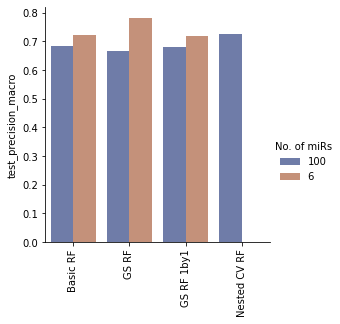

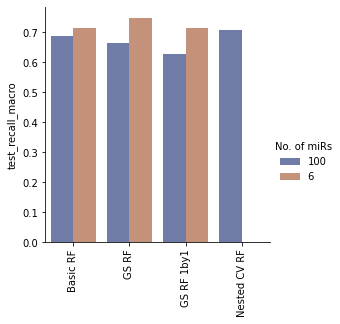

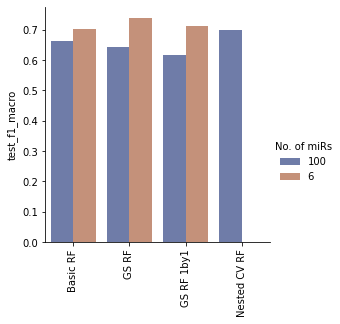

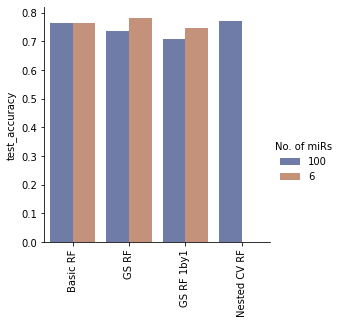

In [75]:
plt.figure(num=4, figsize=(10,30))
for i in range(1,5):
  col=results.columns[i*2]
  data=results[['Model2', 'No. of miRs', col]]
  sns.catplot(data=data, kind="bar", x="Model2", y=col, hue="No. of miRs", ci="sd", palette="dark", alpha=.6, height=4)
  plt.xlabel('')
  plt.tick_params(axis='x', which='major', labelsize=10, rotation=90)
  plt.savefig('RF_metrices_%i.pdf' % i, bbox_inches='tight')